targets.shape=(16, 2)


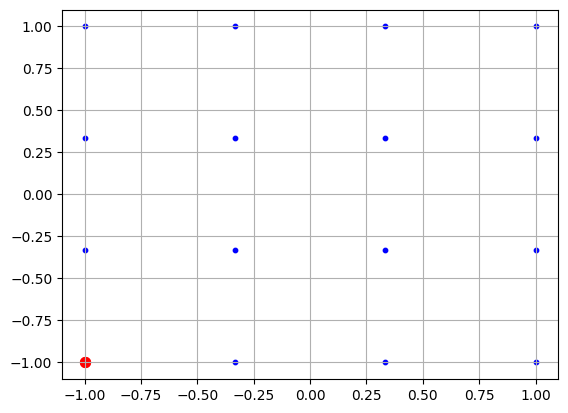

In [15]:
import time
from matplotlib import pyplot as plt
import numpy as np
from socket import *
import threading
from queue import Queue

k=8  # Chose the number of robots        
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(4)

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
depots = np.concatenate((depots, depots))
depot_indices = range(len(targets), len(targets)+len(depots))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = range(len(targets)+len(depots))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [16]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(18, 18)


In [17]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
# Note: All edges are now binary
x = m.addMVar((k,len(node_indices),len(node_indices)), name='x', vtype=GRB.BINARY)
# for ki in range(k):
#     for i in target_indices:
#         for j in target_indices:
#             if i == j: continue
#             _ = m.addConstr(x[ki,i,j] <= 1)
#         for j in depot_indices:
#             _ = m.addConstr(x[ki,i,j] <= 1)
#             _ = m.addConstr(x[ki,j,i] <= 1)

In [18]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i,:].sum() == 1 for i in target_indices)
_ = m.addConstrs(x[:,:,i].sum() == 1 for i in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki,B_k[ki],:].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki,:,B_k[ki]].sum() <= 1)

    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,i]-x[ki,i,:]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)

In [19]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,len(node_indices),len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki,i,j]
    _ = m.addConstr((p[ki,B_k[ki],:] - p[ki,:,B_k[ki]]).sum() == right_side)

    for i in target_indices:
        _ = m.addConstr((p[ki,:,i] - p[ki,i,:]).sum() == x[ki,i,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki,j,i] - p[ki,i,j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i,j] <= len(target_indices) * x[ki,i,j] for i in node_indices for j in node_indices)

In [20]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 2.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node
r = m.addMVar((len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[j] - r[i] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[j] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[j] - cost[j,i] >= -M * (1 - x[ki,j,i]))

In [21]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [22]:
# import datetime
def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki,i,j] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)

        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()

    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)

    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    # fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png")
    plt.show()

In [23]:
def calculate_total_distance(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i + 1]]
    total_cost += cost_matrix[path[-1], path[0]]  # Return to start
    return total_cost

def two_opt(route, cost_matrix):
    best_distance = calculate_total_distance(route, cost_matrix)
    best_route = route.copy()

    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue  # Skip adjacent edges
                new_route = route.copy()
                new_route[i:j] = route[j - 1:i - 1:-1]  # Reverse the segment between i and j
                new_distance = calculate_total_distance(new_route, cost_matrix)

                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route.copy()
                    improved = True

        route = best_route.copy()

    return best_route, best_distance

def k_opt(route, cost_matrix, k):
    best_distance = calculate_total_distance(route, cost_matrix)
    best_route = route.copy()

    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 1):
            for j in range(i + 1, len(route)):
                if j - i < k - 1:
                    continue  # Ensure the segment size is at least k

                new_route = route.copy()
                new_route[i:j] = reversed(route[i:j])  # Reverse the segment between i and j

                new_distance = calculate_total_distance(new_route, cost_matrix)

                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route.copy()
                    improved = True

        route = best_route.copy()

    return best_route, best_distance



def extract_and_calculate_milp_costs(x, start_nodes, num_robots, num_nodes, cost_matrix):
    milp_costs = []
    milp_paths = []

    for ki in range(num_robots):
        current_node = start_nodes[ki]  # Start at the robot's starting node
        path = [current_node]  # Initialize path with start node
        visited = {current_node}  # Set to keep track of visited nodes

        while len(visited) < num_nodes:
            next_node = np.argmax(x[ki, current_node, :])
            if next_node in visited:
                break  # Avoid revisiting nodes
            path.append(next_node)
            visited.add(next_node)
            current_node = next_node

        milp_paths.append(path)
        milp_costs.append(calculate_path_cost(path, cost_matrix))

    return milp_paths, milp_costs


def visualize_individual_paths(paths, nodes, targets, depots, B_k, costs):
    num_robots = len(paths)
    num_rows = (num_robots + 1) // 2  # Two plots per row
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))  # Adjust the figure size as needed

    # Flatten the axs array for easy iteration if there's more than one row
    if num_robots > 2:
        axs = axs.flatten()

    for index, path in enumerate(paths):
        ax = axs[index]

        # Plot targets and depots
        ax.scatter(targets[:, 0], targets[:, 1], c='blue', s=10, label='Targets')
        ax.scatter(depots[:, 0], depots[:, 1], c='red', s=50, label='Depots')

        # Plot path for this robot
        for i in range(len(path) - 1):
            start_node = path[i]
            end_node = path[i + 1]
            ax.plot([nodes[start_node, 0], nodes[end_node, 0]],
                    [nodes[start_node, 1], nodes[end_node, 1]],
                    color="purple", linewidth=1)
            ax.scatter(nodes[start_node, 0], nodes[start_node, 1], c="purple", s=8)

        # Plot a line returning to the starting depot
        ax.plot([nodes[path[-1], 0], nodes[B_k[0], 0]],
                [nodes[path[-1], 1], nodes[B_k[0], 1]],
                color="purple", linewidth=1, linestyle="--", label='Return to Depot')

        # Set title with cost
        ax.set_title(f"Robot #{index + 1} (Cost: {costs[index]:.2f})")
        ax.grid()
        ax.legend()

    # Hide any unused subplots
    for i in range(index + 1, num_rows * 2):
        fig.delaxes(axs[i])

    # plt.tight_layout()
    fig.suptitle(f"Paths for all robots (sum of costs={sum(costs):.3f})")
    plt.show()

def calculate_path_cost(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i + 1]]
    # Add cost of returning to the starting depot
    total_cost += cost_matrix[path[-1], path[0]]
    return total_cost

In [24]:
import gurobipy as grb

class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    selected_nodes = None

    def __init__(self, model, num_threads=1):
        self.model = model
        MILPSolver.selected_nodes = []
        self.num_threads = num_threads
        
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

            # If this solution's maximum costing tour ~= the cost of the tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Number of available CPU threads: 20
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 15 threads

Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu
Optimize a model with 7944 rows, 5203 columns and 40344 nonzeros
Model fingerprint: 0x905cabe6
Variable types: 19 continuous, 5184 integer (2592 binary)
Coefficient statistics:
  Matrix range     [7e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 1266 rows and 290 columns
Presolve time: 0.07s
Presolved: 6678 rows, 4913 columns, 38206 nonzeros
Variable types: 17 continuous, 4896 integer (2448 binary)
Found a new solution with lower cost(51.324)!


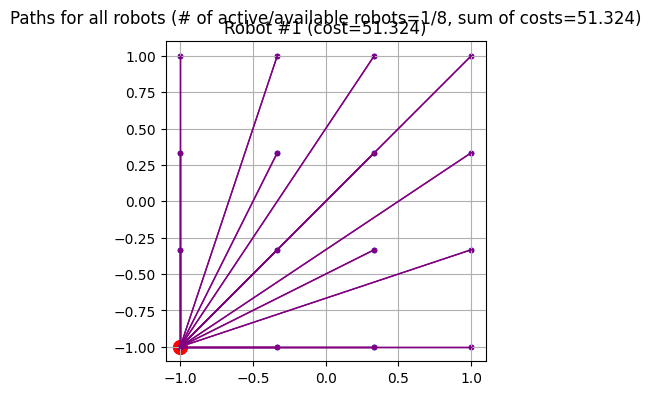

Found heuristic solution: objective 51.3241003
Found a new solution with lower cost(30.241)!


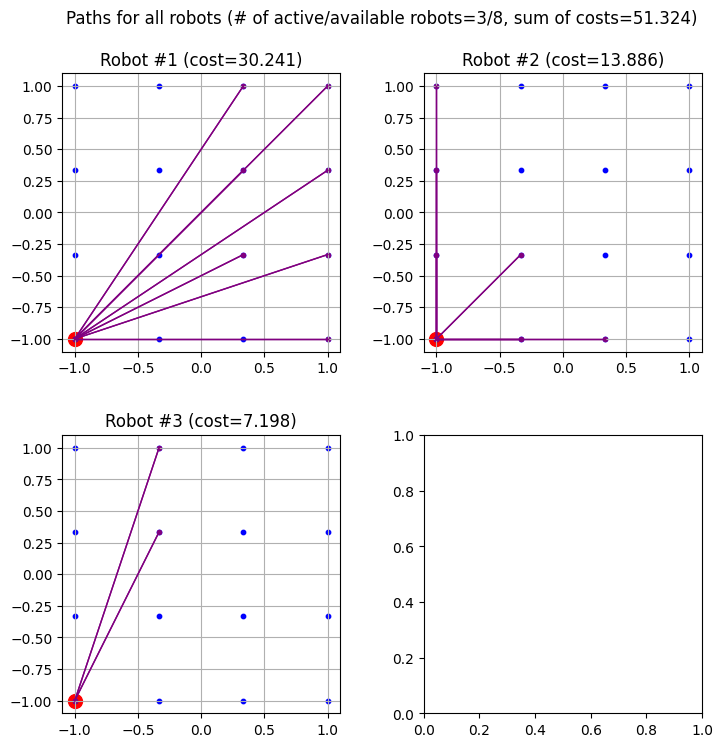

Found heuristic solution: objective 30.2406880

Root relaxation: objective 1.330282e+00, 4543 iterations, 0.31 seconds (0.58 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.33028    0  162   30.24069    1.33028  95.6%     -    2s
Found a new solution with lower cost(11.560)!


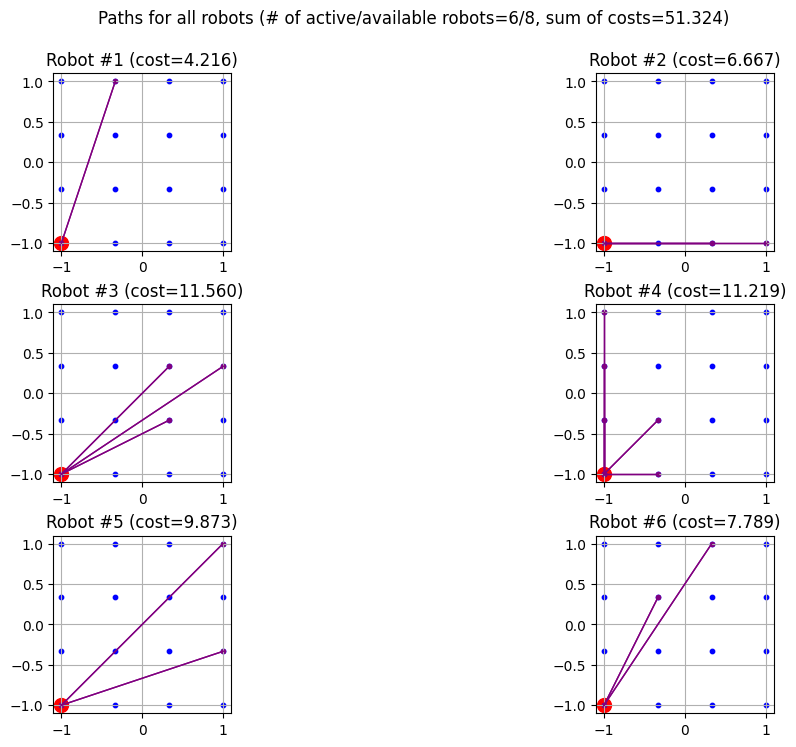

H    0     0                      11.5600618    1.33028  88.5%     -    3s
     0     0    1.33028    0  257   11.56006    1.33028  88.5%     -    3s
Found a new solution with lower cost(9.873)!


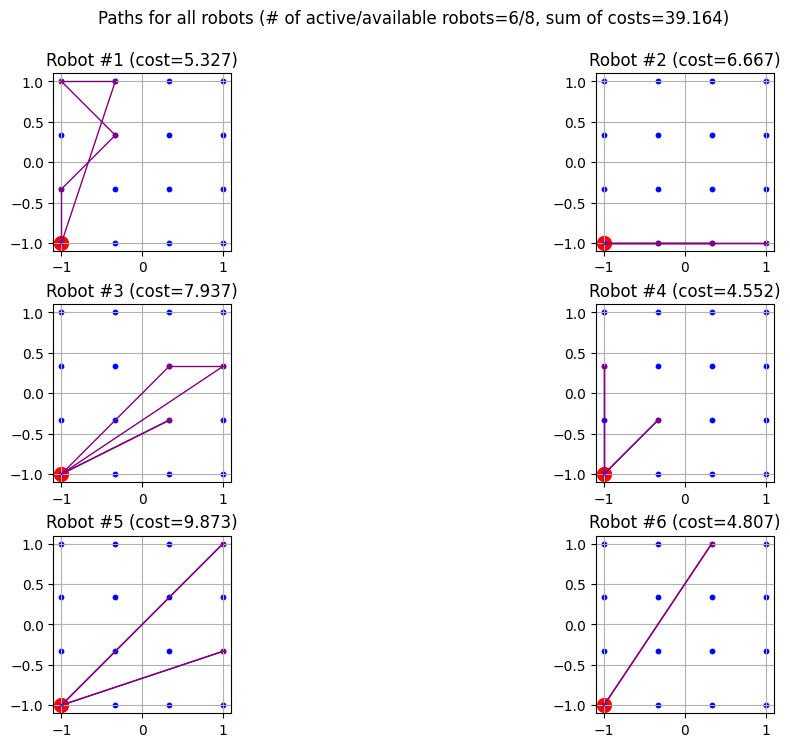

H    0     0                       9.8732245    1.33028  86.5%     -    4s
     0     0    1.33028    0  273    9.87322    1.33028  86.5%     -    5s
Found a new solution with lower cost(8.328)!


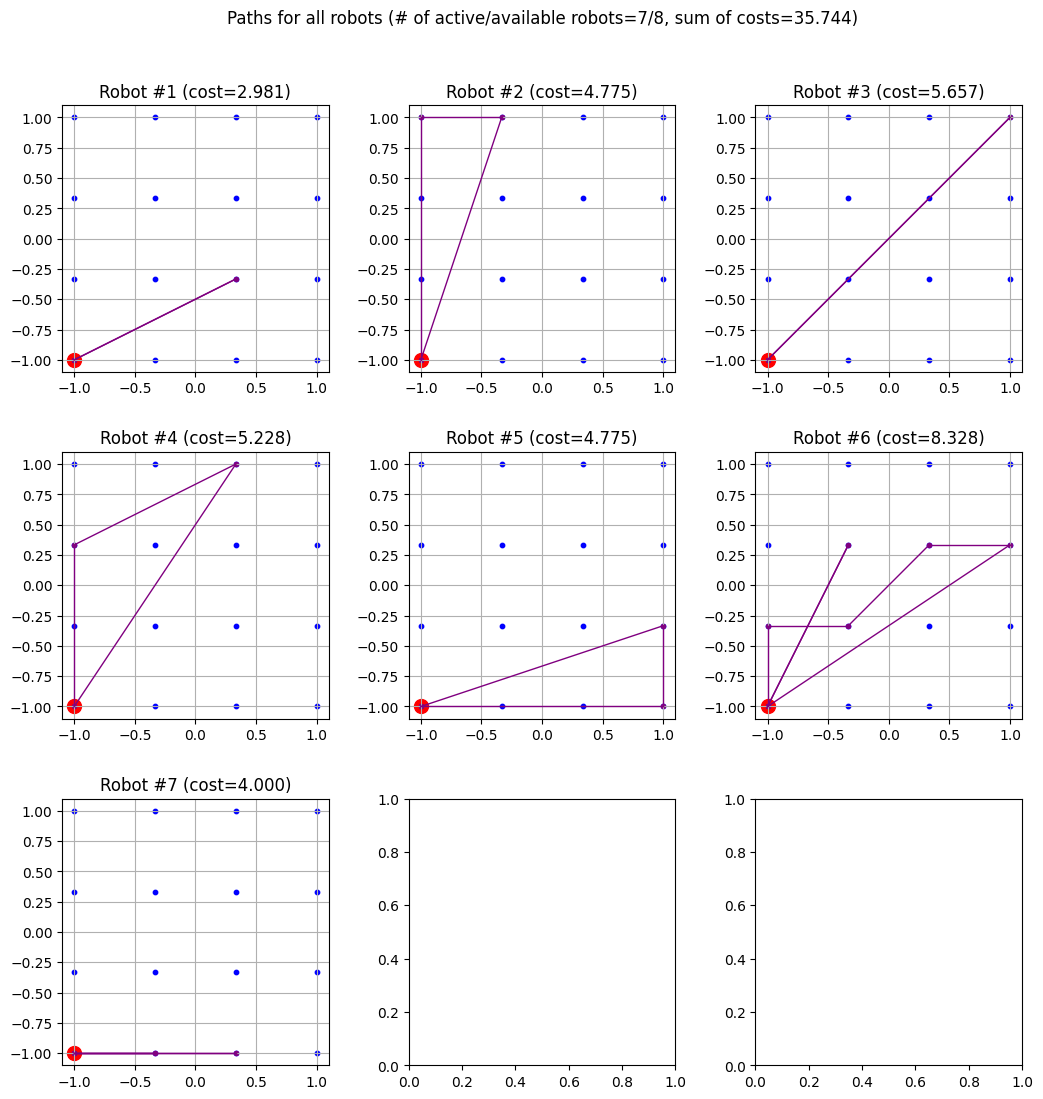

H    0     0                       8.3279339    1.33028  84.0%     -    7s
     0     0    1.33028    0  197    8.32793    1.33028  84.0%     -    7s
Found a new solution with lower cost(5.657)!


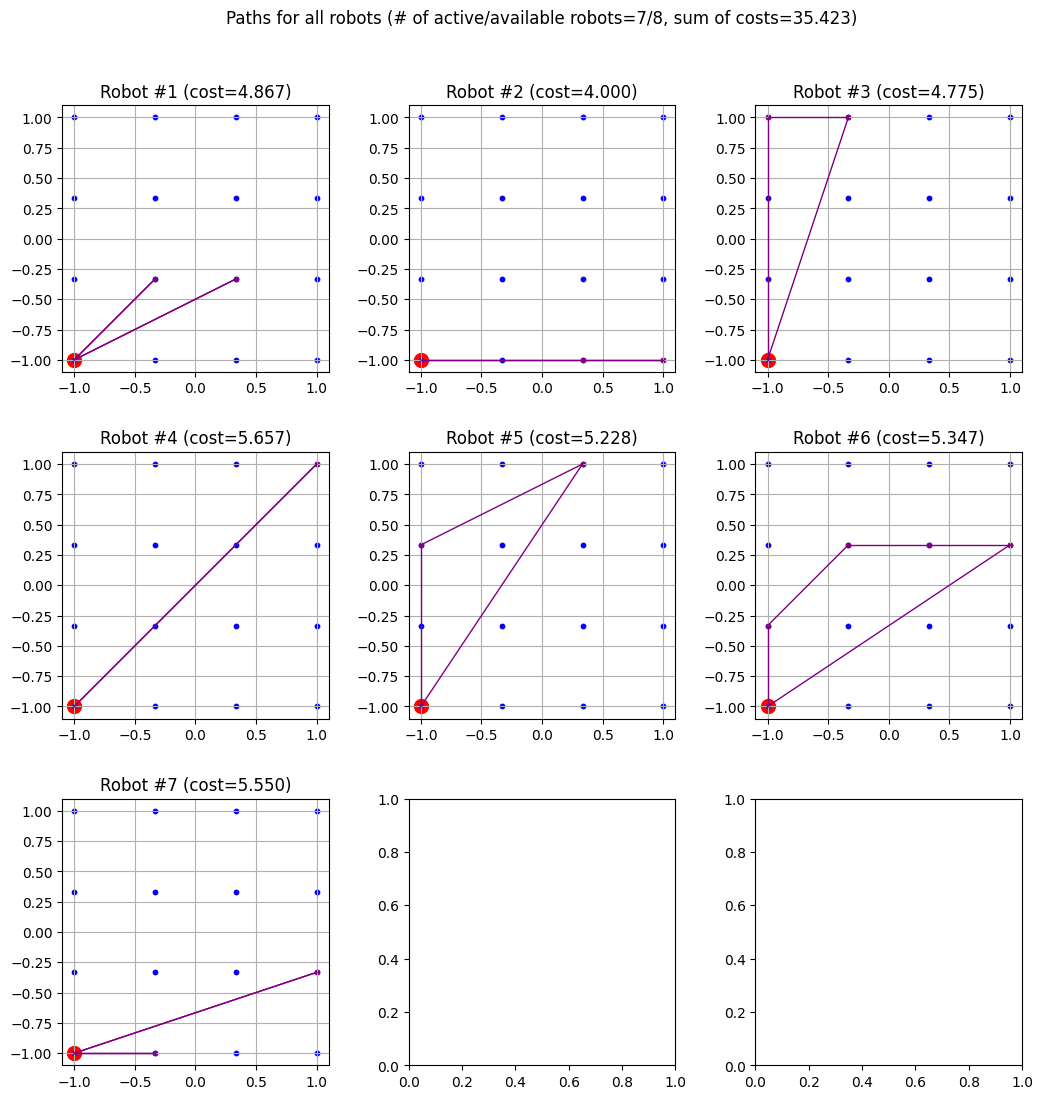

!This is guaranteed to be the optimal solution!
H    0     0                       5.6568542    1.33028  76.5%     -    9s

Cutting planes:
  Gomory: 2
  Lift-and-project: 1
  Implied bound: 1
  MIR: 15
  StrongCG: 2
  Flow cover: 19
  GUB cover: 2
  RLT: 12

Explored 1 nodes (20719 simplex iterations) in 9.29 seconds (4.58 work units)
Thread count was 15 (of 20 available processors)

Solution count 6: 5.65685 8.32793 9.87322 ... 51.3241

Solve interrupted
Best objective 5.656854249492e+00, best bound 1.330282362304e+00, gap 76.4837%

User-callback calls 750, time in user-callback 6.17 sec


In [25]:
import os

# Get the number of available CPU threads
num_threads_available = os.cpu_count()

# Print the number of available CPU threads
print(f"Number of available CPU threads: {num_threads_available}")

num_threads = 15  # Adjust the number of threads as needed

# Create an instance of your MILP solver with multi-threading
solver = MILPSolver(m, num_threads)

# Set the number of threads for Gurobi
grb.setParam('Threads', num_threads)

m._x = x
# solver = MILPSolver(m)
solver.solve() # Optimize until the first optimal solution is found

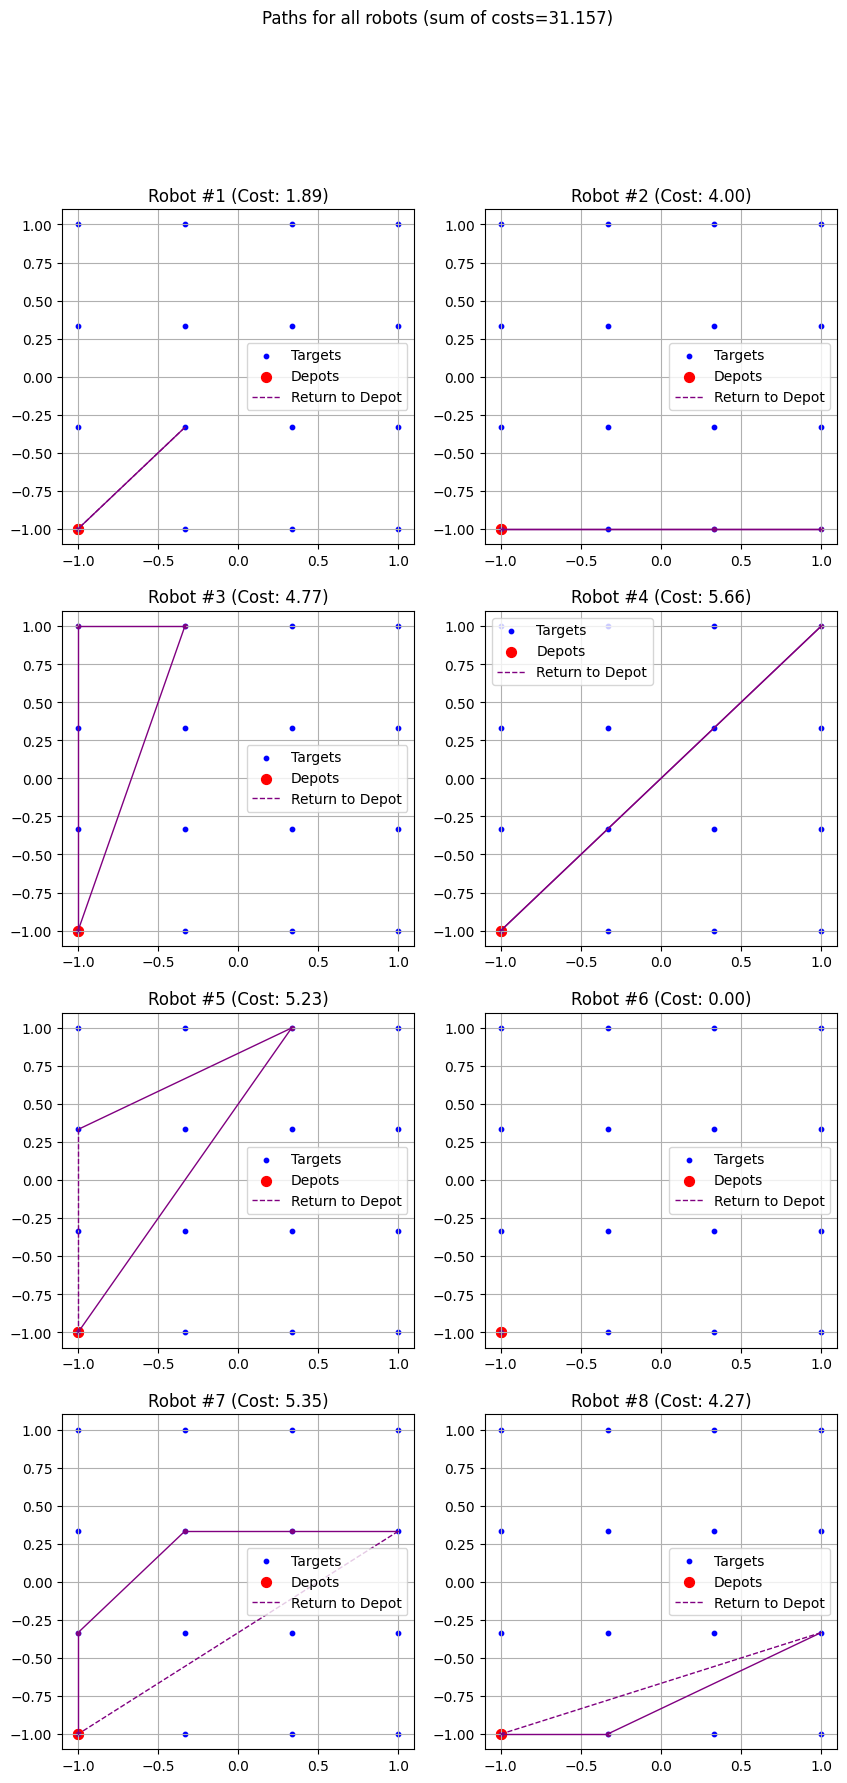

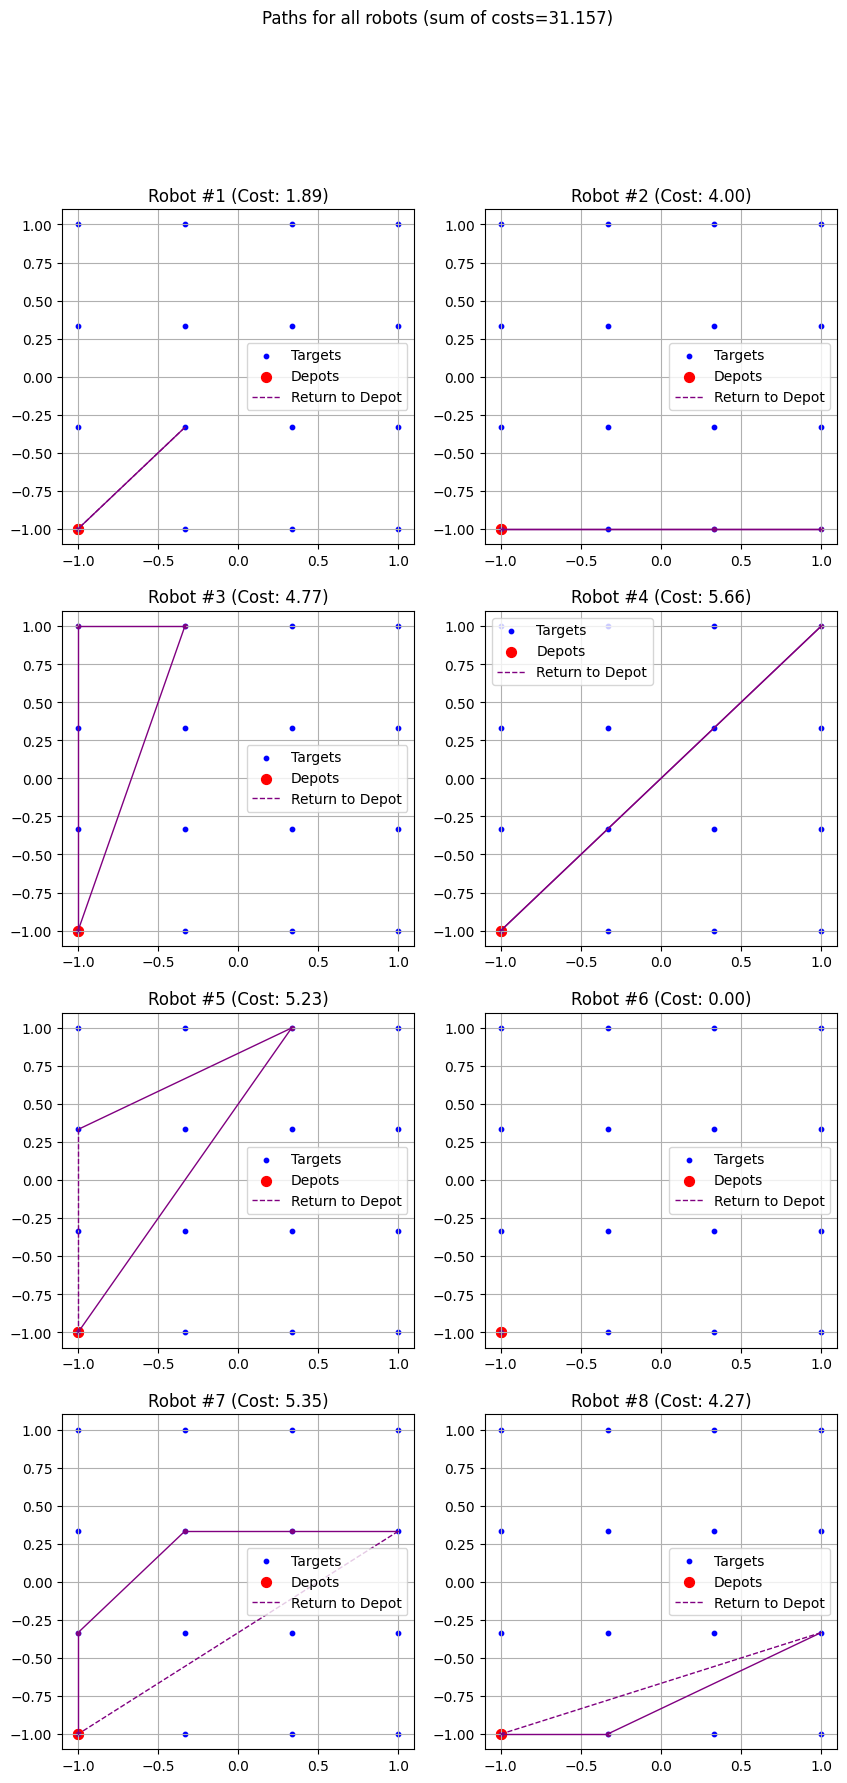

Cost reduction for Robot (two-opt) 1: 0.00
Cost reduction for Robot (two-opt) 2: 0.00
Cost reduction for Robot (two-opt) 3: 0.00
Cost reduction for Robot (two-opt) 4: 0.00
Cost reduction for Robot (two-opt) 5: 0.00
Cost reduction for Robot (two-opt) 6: 0.00
Cost reduction for Robot (two-opt) 7: 0.00
Cost reduction for Robot (two-opt) 8: 1.28
Cost reduction for Robot (k-opt) 1: 0.00
Cost reduction for Robot (k-opt) 2: 0.00
Cost reduction for Robot (k-opt) 3: 0.00
Cost reduction for Robot (k-opt) 4: 0.00
Cost reduction for Robot (k-opt) 5: 0.00
Cost reduction for Robot (k-opt) 6: 0.00
Cost reduction for Robot (k-opt) 7: 0.00
Cost reduction for Robot (k-opt) 8: 1.28


In [26]:
milp_solution_x = np.array([x[ki].X for ki in range(k)]).reshape(k, len(node_indices), len(node_indices))
milp_paths, milp_costs = extract_and_calculate_milp_costs(milp_solution_x, B_k, k, len(node_indices), cost)

# Apply 2-opt/3-opt algorithm to each path -> iteratively remove two/three edges and reconnect the two paths in a different way that reduces the total distance.
optimized_paths_2opt = [] # Initialize an empty list to store optimized paths
optimized_paths_kopt = []
for path in milp_paths:
    opt_path2, opt_dist2 = two_opt(path, cost)
    optimized_paths_2opt.append(opt_path2)
    
    # Apply 3-opt algorithm to each path
    opt_pathk, opt_distk = k_opt(path, cost, 3)
    optimized_paths_kopt.append(opt_pathk)

# Calculate costs for each robot
optimized_costs_2opt = [calculate_path_cost(path, cost) for path in optimized_paths_2opt] #two opt

optimized_costs_kopt = [calculate_path_cost(path, cost) for path in optimized_paths_kopt] # Calculate costs for each robot with 3-opt

# Call the updated visualization function with costs
visualize_individual_paths(optimized_paths_2opt, nodes, targets, depots, B_k, optimized_costs_2opt)
visualize_individual_paths(optimized_paths_kopt, nodes, targets, depots, B_k, optimized_costs_kopt) # three opt

# Calculate cost reduction for each robot
for index, (milp_cost, opt_cost) in enumerate(zip(milp_costs, optimized_costs_2opt)):
    cost_reduction = milp_cost - opt_cost
    print(f"Cost reduction for Robot (two-opt) {index + 1}: {cost_reduction:.2f}")
    
# Calculate cost reduction for each robot
for index, (milp_cost, opt_cost) in enumerate(zip(milp_costs, optimized_costs_kopt)):
    cost_reduction = milp_cost - opt_cost
    print(f"Cost reduction for Robot (k-opt) {index + 1}: {cost_reduction:.2f}")

In [30]:
# from socket import *
# import threading
# 
# def handle_client(connectionSocket, addr):
#     try:
#         # Receive data from the client
#         data = connectionSocket.recv(2048).decode()
#         print(f"Received data from {addr}: {data}")
# 
#         # Send a response back to the client
#         connectionSocket.send("Message received".encode())
# 
#     except Exception as e:
#         print(f"Error receiving data from {addr}. Exception: {e}")
# 
#     finally:
#         connectionSocket.close()
# 
# def start_server(port):
#     serverSocket = socket(AF_INET, SOCK_STREAM)
# 
#     if port != 0:
#         serverSocket.bind(('', port))
#         actual_port = serverSocket.getsockname()[1]
#         print(f'Server is ready to receive on port {actual_port}')
#     else:
#         serverSocket.bind(('', 0))
#         actual_port = serverSocket.getsockname()[1]
#         print(f'Server is ready to receive on a dynamically assigned port: {actual_port}')
# 
#     serverSocket.listen(1)
# 
#     while True:
#         connectionSocket, addr = serverSocket.accept()
#         # Start a new thread to handle the client
#         threading.Thread(target=handle_client, args=(connectionSocket, addr)).start()
# 
# # Start three servers on different threads with different ports
# thread1 = threading.Thread(target=start_server, args=(12001,))  # Start server on port 12001
# thread2 = threading.Thread(target=start_server, args=(12002,))  # Start server on port 12002
# thread3 = threading.Thread(target=start_server, args=(12003,))  # Start server on port 12003
# 
# thread1.start()
# thread2.start()
# thread3.start()


Exception in thread Thread-31 (start_server):
Traceback (most recent call last):
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-32 (start_server):
Traceback (most recent call last):
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
Exception in thread Thread-33 (start_server):
Traceback (most recent call last):
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Samara\AppData\Local\Temp\ipykernel_35112\1305087726.py", line 23, in start_server
        self.run()
  File "C:\Users\Sam

In [31]:
# from socket import *
# import time
# 
# def generate_unique_job_id(robot_id):
#     timestamp = int(time.time())
#     return f"{timestamp}_Robot{robot_id}"
# 
# def send_paths_to_server(paths, server_port, job_id, robot_id):
#     client_socket = socket(AF_INET, SOCK_STREAM)
#     client_socket.connect(('127.0.0.1', server_port))
# 
#     try:
#         # Prepare the data to be sent (assuming paths is a list of paths for each robot)
#         data = {
#             'job_id': f"{job_id}_Robot{robot_id}",  # Using a combination of job_id and robot_id
#             'robot_id': robot_id,
#             'paths': paths
#         }
# 
#         # Convert data to a string before sending
#         message = str(data)
# 
#         # Send the message to the server
#         client_socket.send(message.encode())
# 
#         # Receive and print the response from the server
#         response = client_socket.recv(2048).decode()
#         print('From server:', response)
# 
#     except Exception as e:
#         print(f"Error during connection: {e}")
# 
#     finally:
#         client_socket.close()
# 
# # Assuming you have the optimized paths from the 2-opt algorithm
# # For each robot, send the paths to the server with a unique job ID
# for robot_id, paths_2opt in enumerate(optimized_paths_2opt, start=1):
#     send_paths_to_server(paths_2opt, server_port=12003, job_id=generate_unique_job_id(robot_id), robot_id=robot_id)


Received data from ('127.0.0.1', 56550): {'job_id': '1706892499_Robot1_Robot1', 'robot_id': 1, 'paths': [16, 17, 5]}
From server: Message received
Received data from ('127.0.0.1', 56553): {'job_id': '1706892499_Robot2_Robot2', 'robot_id': 2, 'paths': [16, 0, 8, 12, 17]}
From server: Message received
Received data from ('127.0.0.1', 56554): {'job_id': '1706892499_Robot3_Robot3', 'robot_id': 3, 'paths': [16, 7, 3, 17]}
From server: Message received
Received data from ('127.0.0.1', 56555): {'job_id': '1706892499_Robot4_Robot4', 'robot_id': 4, 'paths': [16, 15, 17]}
From server: Message received
Received data from ('127.0.0.1', 56556): {'job_id': '1706892499_Robot5_Robot5', 'robot_id': 5, 'paths': [16, 11, 2]}
From server: Message received
Received data from ('127.0.0.1', 56557): {'job_id': '1706892499_Robot6_Robot6', 'robot_id': 6, 'paths': [16, 0]}
From server: Message received
Received data from ('127.0.0.1', 56558): {'job_id': '1706892499_Robot7_Robot7', 'robot_id': 7, 'paths': [16, 17

    self.run()
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self.run()
  File "C:\Users\Samara\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Samara\AppData\Local\Temp\ipykernel_35112\3914746943.py", line 23, in start_server
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Samara\AppData\Local\Temp\ipykernel_35112\3914746943.py", line 23, in start_server
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Samara\AppData\Local\Temp\ipykernel_35112\3914746943.py", line 23, in start_server
OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted
OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is 